In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

dataset = pd.read_csv("bitcoin.csv")
dataset["Date"] = pd.to_datetime(dataset.Date, format = "%b %d, %Y")
dataset.index = dataset['Date']

In [50]:
#sorting data
dataset = dataset.sort_index(ascending = True, axis = 0)
dataset.dtypes

Date        datetime64[ns]
Price               object
Open                object
High                object
Low                 object
Vol.                object
Change %            object
dtype: object

In [51]:
dataset.tail()

,Date,Price,Open,High,Low,Vol.,Change %
Date,,,,,,,
2022-12-17,2022-12-17,"16,777.1","16,629.0","16,794.4","16,587.0",164.49K,0.89%
2022-12-18,2022-12-18,"16,741.1","16,777.0","16,825.7","16,666.5",124.29K,-0.21%
2022-12-19,2022-12-19,"16,441.3","16,741.1","16,809.5","16,331.2",207.93K,-1.79%
2022-12-20,2022-12-20,"16,902.8","16,441.3","17,031.3","16,400.7",284.57K,2.81%
2022-12-21,2022-12-21,"16,874.2","16,902.7","16,919.4","16,780.6",221.50K,-0.17%


In [52]:
dataset.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace = True)
dataset.tail()

,Date,Price
Date,,
2022-12-17,2022-12-17,"16,777.1"
2022-12-18,2022-12-18,"16,741.1"
2022-12-19,2022-12-19,"16,441.3"
2022-12-20,2022-12-20,"16,902.8"
2022-12-21,2022-12-21,"16,874.2"


In [53]:
dataset['Price'] = dataset['Price'].astype(dtype = "string")
dataset['Price'] = dataset['Price'].str.replace(',', '')

In [54]:
dataset.tail()

,Date,Price
Date,,
2022-12-17,2022-12-17,16777.1
2022-12-18,2022-12-18,16741.1
2022-12-19,2022-12-19,16441.3
2022-12-20,2022-12-20,16902.8
2022-12-21,2022-12-21,16874.2


In [55]:
dataset['Price'] = pd.to_numeric(dataset['Price'])
dataset.tail()

,Date,Price
Date,,
2022-12-17,2022-12-17,16777.1
2022-12-18,2022-12-18,16741.1
2022-12-19,2022-12-19,16441.3
2022-12-20,2022-12-20,16902.8
2022-12-21,2022-12-21,16874.2


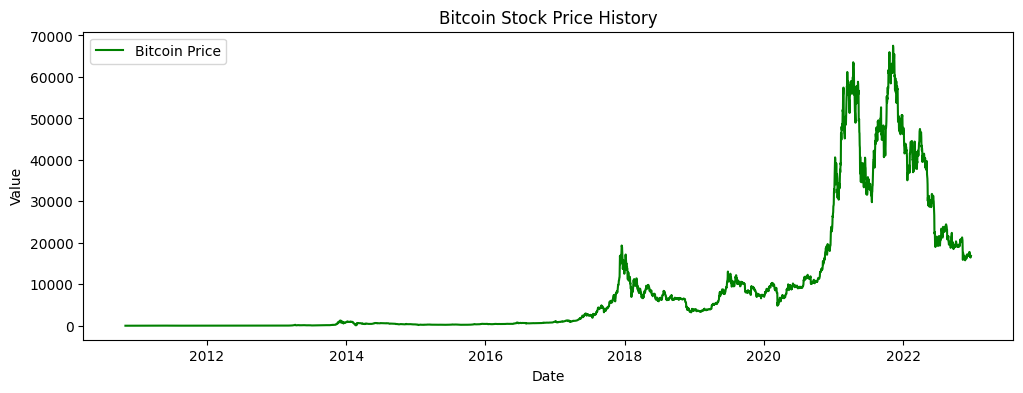

In [56]:
#plot bitcoin stock data
plt.figure(figsize = (12, 4))
plt.plot(dataset.index, dataset["Price"], color = 'g', label = 'Bitcoin Price')


plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Bitcoin Stock Price History")
plt.legend()

In [57]:
scaler = MinMaxScaler(feature_range = (0, 1))

Epoch 1/5
3497/3497 - 54s - loss: 5.2219e-04 - 54s/epoch - 16ms/step
Epoch 2/5
3497/3497 - 51s - loss: 1.0577e-04 - 51s/epoch - 15ms/step
Epoch 3/5
3497/3497 - 52s - loss: 6.9409e-05 - 52s/epoch - 15ms/step
Epoch 4/5
3497/3497 - 53s - loss: 3.6294e-05 - 53s/epoch - 15ms/step
Epoch 5/5
3497/3497 - 55s - loss: 3.5982e-05 - 55s/epoch - 16ms/step
28/28 [==============================] - 1s 13ms/step


C:\Users\kkacz\AppData\Local\Temp\ipykernel_8872\4012122853.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData['Predictions'] = predictedPrice


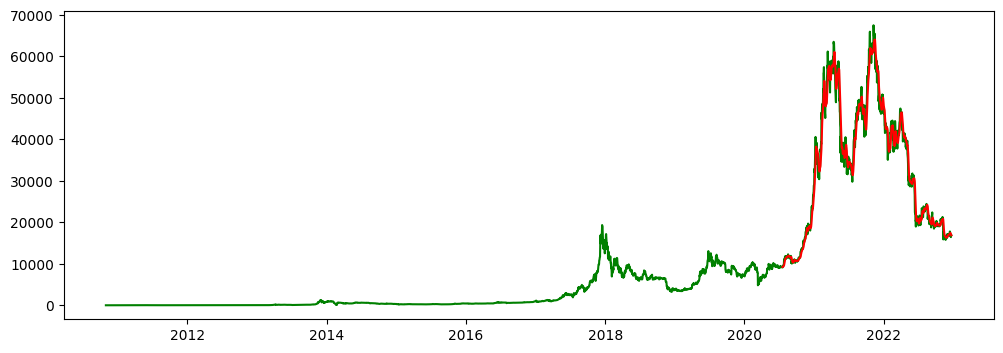

In [58]:
#preparing training and testing dataset 
dataset["Date"] = pd.to_numeric(pd.to_datetime(dataset["Date"]))
data = dataset.values
trainDataLength = round(0.8 * len(data))
testData = data[trainDataLength + 1:, :]
scaledData = scaler.fit_transform(data)

dataset.drop(['Date'], axis = 1, inplace = True)
x_train, y_train = [], []
    
for j in range(50, trainDataLength):

    x_train.append(scaledData[j - 50 : j, 0])
    y_train.append(scaledData[j, 0])
    
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#creating a sequential model and training the neural network
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(units = 50))
model.add(Dense(1))
    
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(x_train, y_train, epochs = 5, batch_size = 1, verbose = 2)

#scaling test data
inputData = dataset[len(dataset) - len(testData) - 50:].values
inputData = inputData.reshape(-1, 1)
scalerInput = MinMaxScaler(feature_range = (0, 1))
inputData = scalerInput.fit_transform(inputData)

test = []
for k in range(50, inputData.shape[0]):
    test.append(inputData[k - 50 : k, 0])

test = np.array(test)
test = np.reshape(test, (test.shape[0], test.shape[1], 1))

#prediction of stock price based on trained model
predictedPrice = model.predict(test)
    
#inverse transform from scaler
predictedPrice = scalerInput.inverse_transform(predictedPrice)

#saving a file
nameOfFile = "bitcoin" + ".h5"
model.save(nameOfFile)

nameOfFile = "bitcoin" + ".json"
model_json = model.to_json()

with open(nameOfFile, "w") as json_file:
    json_file.write(model_json)

#plot
trainData = dataset[:trainDataLength]
testData = dataset[trainDataLength + 1:]
testData['Predictions'] = predictedPrice

plt.figure(figsize = (12, 4))
plt.plot(trainData["Price"], color = 'g')
plt.plot(testData["Price"], color ='g')
plt.plot(testData["Predictions"], color = 'r')